In [6]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

scanpy==1.9.8 anndata==0.9.2 umap==0.5.7 numpy==1.22.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.8 pynndescent==0.5.13
squidpy==1.2.3
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# LOAD ACTUAL DATA

adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

In [8]:
# LOAD SC EMBEDDINGS
adata_sc_embeddings = sc.read_h5ad("/n/data1/hms/dbmi/zitnik/lab/users/lucia1215/tangram/mouse_embeddings_sc_embeddings_20250421_122340.h5ad")
print(adata_sc_embeddings.obs)

                             sample_name      organism donor_sex  \
F2S4_151217_005_B01  F2S4_151217_005_B01  Mus musculus         M   
F2S4_151217_005_C01  F2S4_151217_005_C01  Mus musculus         M   
F2S4_151217_005_E01  F2S4_151217_005_E01  Mus musculus         M   
F2S4_151217_005_F01  F2S4_151217_005_F01  Mus musculus         M   
F2S4_151217_005_G01  F2S4_151217_005_G01  Mus musculus         M   
...                                  ...           ...       ...   
F1S4_180124_317_D01  F1S4_180124_317_D01  Mus musculus         F   
F1S4_180124_317_E01  F1S4_180124_317_E01  Mus musculus         F   
F1S4_180124_317_F01  F1S4_180124_317_F01  Mus musculus         F   
F1S4_180124_317_G01  F1S4_180124_317_G01  Mus musculus         F   
F1S4_180124_317_H01  F1S4_180124_317_H01  Mus musculus         F   

                        cell_class cell_subclass      cell_cluster  \
F2S4_151217_005_B01      GABAergic         Pvalb        Pvalb Tpbg   
F2S4_151217_005_C01  Glutamatergic         

In [12]:
# LOAD ST EMBEDDINGS

# n/data1/hms/dbmi/zitnik/lab/users/lucia1215/scGPT/mouse_data/mouse_embeddings_st_embeddings_20250415_164904.h5ad
# /n/data1/hms/dbmi/zitnik/lab/users/lucia1215/tangram/mouse_embeddings_st_embeddings_20250415_164904.h5ad
adata_st_embeddings = sc.read_h5ad("mouse_embeddings_st_embeddings_20250415_164904.h5ad")

In [3]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

/n/data1/hms/dbmi/zitnik/lab/users/lucia1215/conda_envs/tangram_test/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/n/data1/hms/dbmi/zitnik/lab/users/lucia1215/conda_envs/tangram_test/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/n/data1/hms/dbmi/zitnik/lab/users/lucia1215/

1401

In [8]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [9]:
# Create the augmented matrices
# For single-cell data
# Need to redo this with the current obs column names
H_sc = adata_sc_embeddings.X.toarray() if not isinstance(adata_sc_embeddings.X, np.ndarray) else adata_sc_embeddings.X
H_sc_emb = adata_sc_embeddings.obsm["X_scGPT"]
H_sc_augmented = np.hstack([H_sc, H_sc_emb])

In [13]:
# Create the augmented matrices
# For ST data
H_st = adata_st_embeddings.X.toarray() if not isinstance(adata_st_embeddings.X, np.ndarray) else adata_st_embeddings.X
H_st_emb = adata_st_embeddings.obsm["X_scGPT"]
H_st_augmented = np.hstack([H_st, H_st_emb])

: 

: 

: 

In [10]:
# Create a new AnnData with augmented matrix
adata_sc_augmented = sc.AnnData(X=H_sc_augmented)
adata_sc_augmented.obs = adata_sc.obs.copy()
adata_sc_augmented.uns = adata_sc.uns.copy()  # Copy training_genes and other Tangram info

NameError: name 'H_sc_augmented' is not defined

In [10]:
ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    mode="cells",
#     mode="clusters",
#     cluster_label='cell_subclass',  # .obs field w cell types
    density_prior='rna_count_based',
    num_epochs=500,
    # device="cuda:0",
    device='cpu',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.613, KL reg: 0.001
Score: 0.733, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000


INFO:root:Saving results..


In [13]:
# Get the original data and embeddings
H_sc = adata_sc.X.toarray() if not isinstance(adata_sc.X, np.ndarray) else adata_sc.X
H_sc_emb = adata_sc_embeddings.obsm["X_scGPT"]

In [14]:
# Print the shapes to verify
print(f"Original data shape: {H_sc.shape}")
print(f"Embeddings shape: {H_sc_emb.shape}")

Original data shape: (21697, 36826)
Embeddings shape: (21697, 512)


In [15]:
# Create the augmented matrix
H_sc_augmented = np.hstack([H_sc, H_sc_emb])
print(f"Augmented matrix shape: {H_sc_augmented.shape}")

Augmented matrix shape: (21697, 37338)


In [16]:
# Create a new AnnData with the correct dimensions
adata_sc_augmented = sc.AnnData(X=H_sc_augmented)

In [17]:
# Create new var names with the CORRECT number of embedding dimensions
n_genes = H_sc.shape[1]
n_emb_dims = H_sc_emb.shape[1]
print(f"Number of genes: {n_genes}")
print(f"Number of embedding dimensions: {n_emb_dims}")

Number of genes: 36826
Number of embedding dimensions: 512


In [18]:
# Create variable names that match the number of columns
var_names = list(adata_sc.var_names) + [f"emb_dim_{i}" for i in range(n_emb_dims)]
print(f"Total number of variable names: {len(var_names)}")

Total number of variable names: 37338


In [19]:
# Verify that the length matches
if len(var_names) != H_sc_augmented.shape[1]:
    print("ERROR: Variable names length doesn't match number of columns!")
    print(f"Variable names length: {len(var_names)}")
    print(f"Columns in augmented data: {H_sc_augmented.shape[1]}")
else:
    # Only assign if lengths match
    adata_sc_augmented.var_names = pd.Index(var_names)
    print("Variable names assigned successfully")

Variable names assigned successfully


In [21]:
tg.pp_adatas(adata_sc_augmented, adata_st, genes=markers)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [22]:
ad_map_augmented = tg.map_cells_to_space(adata_sc_augmented, adata_st,
    mode="cells",
#     mode="clusters",
#     cluster_label='cell_subclass',  # .obs field w cell types
    density_prior='rna_count_based',
    num_epochs=500,
    # device="cuda:0",
    device='cpu',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.613, KL reg: 0.001
Score: 0.733, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000


INFO:root:Saving results..


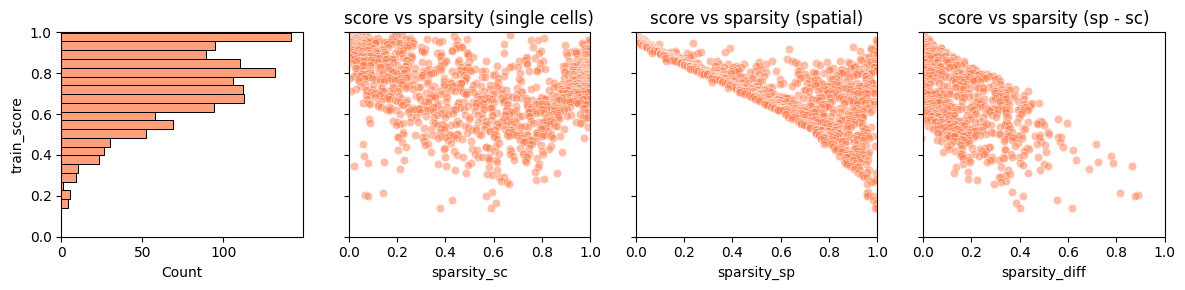

In [25]:
tg.plot_training_scores(ad_map_augmented, bins=20, alpha=.5)

In [9]:
adata_sc = sc.read_h5ad("mouse_embeddings_embeddings_20250414_101308.h5ad")

In [10]:
# get the training gene markers
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1300

In [12]:
# First preprocess the original data
tg.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:1300 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14784 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [13]:
# Get the original expression data for training genes
training_genes = adata_sc.uns['training_genes']
X_train = adata_sc[:, training_genes].X.toarray() if not isinstance(adata_sc.X, np.ndarray) else adata_sc[:, training_genes].X

In [19]:
# Instead of replacing the entire X matrix, create a new AnnData with just training genes
adata_sc_train = adata_sc[:, training_genes].copy()
X_train = adata_sc_train.X.toarray() if not isinstance(adata_sc_train.X, np.ndarray) else adata_sc_train.X

In [14]:
# Get cell embeddings
cell_embeddings = adata_sc.obsm["X_scGPT"]

In [20]:
# Scale embeddings to match expression data scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(cell_embeddings)

# Modify the training genes expression data
for i in range(min(cell_embeddings.shape[1], X_train.shape[1])):
    # Blend embedding dimension with corresponding gene expression
    factor = 0.2  # Weight for the embedding influence
    X_train[:, i] = (1-factor) * X_train[:, i] + factor * embeddings_scaled[:, i % embeddings_scaled.shape[1]]

# Replace the X matrix in the training genes AnnData
adata_sc_train.X = X_train

In [24]:
# trying again with a different blend factor

# Scale embeddings to match expression data scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(cell_embeddings)

# Modify the training genes expression data
for i in range(min(cell_embeddings.shape[1], X_train.shape[1])):
    # Blend embedding dimension with corresponding gene expression
    factor = 0.5  # Weight for the embedding influence
    X_train[:, i] = (1-factor) * X_train[:, i] + factor * embeddings_scaled[:, i % embeddings_scaled.shape[1]]

adata_sc_train_modified = adata_sc_train.copy()
# Replace the X matrix in the training genes AnnData
adata_sc_train_modified.X = X_train

In [21]:
# Run Tangram mapping with modified data
ad_map = tg.map_cells_to_space(
    adata_sc_train, 
    adata_st,
    mode="cells",
    density_prior='rna_count_based',
    num_epochs=500,
    device='cpu',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1300 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.646, KL reg: 0.001
Score: 0.741, KL reg: 0.000
Score: 0.744, KL reg: 0.000
Score: 0.744, KL reg: 0.000
Score: 0.745, KL reg: 0.000


INFO:root:Saving results..


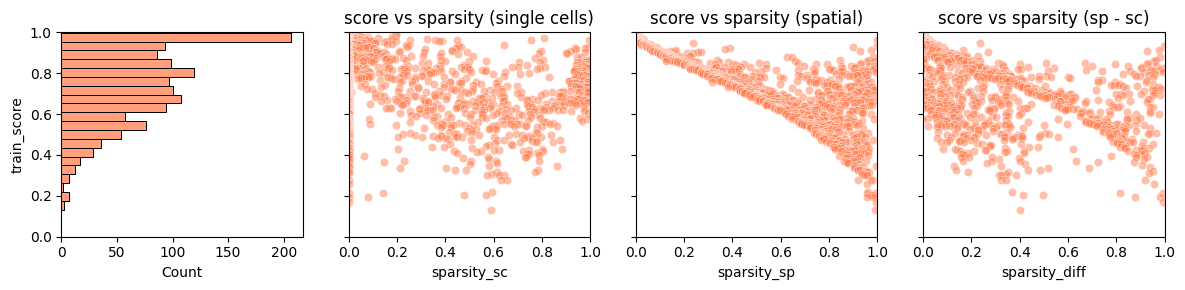

In [23]:
tg.plot_training_scores(ad_map, bins=20, alpha=.5)

In [ ]:
# blend factor 0.5

# Run Tangram mapping with modified data
ad_map = tg.map_cells_to_space(
    adata_sc_train_modified, 
    adata_st,
    mode="cells",
    density_prior='rna_count_based',
    num_epochs=500,
    device='cpu',
)

In [4]:
adata_sc_augmented = sc.read_h5ad("adata_sc_augmented.h5ad")
adata_st_augmented = sc.read_h5ad("adata_st_augmented.h5ad")

In [ ]:
tg.pp_adatas(adata_sc_augmented, adata_st_augmented, genes=markers)

AttributeError: module 'tangram' has no attribute 'pp_adatas'

: 